### Source: hiroto/flare_DS_Tuc_A.ipynb


In [1]:
import os
import sys
import re
from pathlib import Path
from pprint import pprint

import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project:', PROJECT_ROOT)


Project: /Users/daisukeyamashiki/Documents/kyoto-flare-detection


In [2]:
from src.flarepy_DS_Tuc_A import FlareDetector_DS_Tuc_A

# EK_Dra のデータ１つに対してインスタンスを作成

- for ループで回してグラフを表示できるように辞書の中にインタンスを入れる
- 辞書のキーはファイル名から取得する
- 全ての計算処理は、インスタンス生成時に自動で行えるようにする。
- 途中の計算結果の配列は、インスタンス変数として全て保持するように`flarepy_improved.py`を変更した。
- 観測時間順に辞書をソートして、後で for ループで回してグラフを表示する際に観測時間順に表示できるようにする。


In [3]:
# "DS_Tuc_A" フォルダーのパス。上の`print(os.getcwd())`の結果を参考に各自自分の環境に合わせて変更してください。
folder_path = PROJECT_ROOT / "data" / "TESS" / "DS_Tuc_A"

# フォルダー内のファイルリスト（Pathオブジェクトとして保持）
file_list = sorted(folder_path.glob("*.fits"))

# FlareDetector_DS_Tuc_Aインスタンスを格納するための辞書を作成
detectors = {}

# フォルダー内のファイルをループ処理
for file_path in file_list:
    file_name = file_path.name

    # 正規表現を使ってファイル名から "s" の後の4桁の数字を抽出
    # 例: "tess2018206045859-s0001-0000000027214766-0120-s_lc.fits" -> "s0001"
    match = re.search(r'-s\d{4}-', file_name)
    s_number = match.group(0)[1:-1] if match else None

    if not s_number:
        continue

    # 動的なインスタンス名を生成
    instance_name = f"detector_{s_number}"

    # FlareDetector_DS_Tuc_Aクラスのインスタンスを作成
    # process_data=True にすると、データの読み込みと処理が自動で行われる
    detector = FlareDetector_DS_Tuc_A(file=file_path, process_data=True)

    # インスタンスを辞書に格納
    detectors[instance_name] = detector

# 観測時刻順にソート(lambda関数を使用）
# 各インスタンスのtessBJDの配列の最初の値が小さい順
detectors = dict(sorted(detectors.items(), key=lambda x: x[1].tessBJD[0]))

# FlareDetector_DS_Tuc_Aインスタンスを格納するための辞書を作成 (process_data_2用)
detectors_2 = {}

# フォルダー内のファイルをループ処理（detectors_2を作成）
for file_path in file_list:
    file_name = file_path.name

    # 正規表現を使ってファイル名から "s" の後の4桁の数字を抽出
    match = re.search(r'-s\d{4}-', file_name)
    s_number = match.group(0)[1:-1] if match else None

    if not s_number:
        continue

    instance_name = f"detector_{s_number}"
    detector_2 = FlareDetector_DS_Tuc_A(file=file_path, run_process_data_2=True)
    detectors_2[instance_name] = detector_2

# 観測時刻順にソート
detectors_2 = dict(sorted(detectors_2.items(), key=lambda x: x[1].tessBJD[0]))

# 使い方

### 上のセルで計算は全て終わっているので、欲しい値を取得するだけで良い。

- `show_variables()`メゾットで取得できる値の一覧を表示できる。
- `detectors["detector_s0021"]`と、辞書のキーを指定することでデータのインスタンスを選ぶことができる。
- 全てのデータについて一気に見たい時は以下のようにする。

```
for instance in detectors.values():
    instance.tessBJD # インスタンス変数は`instance.変数名`で取得できる
    instance.plot_flare() # インスタンスメゾットは`instance.メゾット名()`で呼び出せる
```

### 以下のメゾットを使うことができる。（`flarepy_improved.py`で定義）

- `plot_flare()`メゾットでフレアの生データと検出されたフレアのグラフを表示できる。
- `plot_energy()`メゾットでフレアのエネルギーのグラフを表示できる。

### クラス変数を使って、全てのインスタンスのフレアの検出割合を集計している。

- `array_flare_ratio`内に、フレアの検出割合を集計
- `array_observation_time`内に、観測時間を集計


In [4]:
from plotly.subplots import make_subplots


def plot_comparison(detector_1, detector_2):
    """
    2つのFlareDetector_DS_Tuc_Aインスタンスの生の光度曲線を比較表示する関数。

    Parameters
    ----------
    detector_1 : FlareDetector_DS_Tuc_A
        process_data=True で処理されたインスタンス。
    detector_2 : FlareDetector_DS_Tuc_A
        run_process_2=True (またはprocess_data_2=True) で処理されたインスタンス。
    """
    # 2つのインスタンスでデータが処理されているかを確認
    if detector_1.mPDCSAPflux is None or detector_2.mPDCSAPflux is None:
        print("Error: 比較対象のインスタンスのどちらか、または両方でデータが処理されていません。")
        return

    # グラフの作成 (2行1列のサブプロット)
    # subplot_titles で各プロットのタイトルを設定
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=("Processed with 'process_data'", "Processed with 'process_data_2'"),
    )

    # --- 上のプロット (process_data で処理したデータ) ---
    fig.add_trace(
        go.Scatter(
            x=detector_1.tessBJD,
            y=detector_1.mPDCSAPflux,
            mode="lines",
            line=dict(color="blue", width=1),
            name="process_data Flux",  # 凡例用の名前
        ),
        row=1,
        col=1,
    )
    fig.update_yaxes(title_text="Normalized Flux", row=1, col=1)

    # --- 下のプロット (process_data_2 で処理したデータ) ---
    fig.add_trace(
        go.Scatter(
            x=detector_2.tessBJD,
            y=detector_2.mPDCSAPflux,
            mode="lines",
            line=dict(color="red", width=1),  # 見分けやすいように色を変更
            name="process_data_2 Flux",  # 凡例用の名前
        ),
        row=2,
        col=1,
    )

    # X軸とY軸のラベル設定
    fig.update_yaxes(title_text="Normalized Flux", row=2, col=1)
    # X軸は共有されているので、一番下のプロットにのみタイトルを設定
    fig.update_xaxes(title_text="Time (BJD - 2457000)", row=2, col=1)

    # 全体のレイアウト設定
    # data_nameは同じファイルなので detector_1 のものを代表して使用
    fig.update_layout(
        title_text=f"Raw Light Curve Comparison ({detector_1.data_name})",
        height=700,  # 2つのプロットなので高さを調整
        showlegend=False,  # サブプロットタイトルで十分なので凡例は非表示
    )

    fig.show()

In [5]:
# --- 以下は実行用のサンプルコードです ---

# 1. 必要なライブラリとクラスをインポート
# import os
# from your_flare_detector_file import FlareDetector_DS_Tuc_A # あなたのクラス定義をインポート

# 2. 比較したいセクターのファイルパスを指定
# (例)
# file_path = "./DS_Tuc_A/tess2018206045859-s0001-0000000027214766-0120-s_lc.fits"

# 3. 2つの方法でインスタンスを作成
print(f"Processing {file_path} with 'process_data'...")
detector_1 = FlareDetector_DS_Tuc_A(file=file_path, process_data=True)

print(f"Processing {file_path} with 'process_data_2'...")
detector_2 = FlareDetector_DS_Tuc_A(file=file_path, run_process_data_2=True)


# 4. 作成した関数を呼び出してプロット
# detector_1とdetector_2の両方でデータが正常に処理されていれば、グラフが表示される
if detector_1 and detector_2:
    print("Plotting comparison...")
    plot_comparison(detector_1, detector_2)
    print("Done.")

Processing /Users/daisukeyamashiki/Documents/kyoto-flare-detection/data/TESS/DS_Tuc_A/tess2023209231226-s0068-0000000410214986-0262-s_lc.fits with 'process_data'...
Processing /Users/daisukeyamashiki/Documents/kyoto-flare-detection/data/TESS/DS_Tuc_A/tess2023209231226-s0068-0000000410214986-0262-s_lc.fits with 'process_data_2'...
Plotting comparison...


Done.


In [6]:
import os


def plot_overlay_comparison(detector_1, detector_2):
    """
    2つのFlareDetector_DS_Tuc_Aインスタンスの生の光度曲線を重ねて比較表示する関数。
    """
    fig = go.Figure()

    # 'process_data' の結果 (黒)
    fig.add_trace(
        go.Scatter(x=detector_1.tessBJD, y=detector_1.mPDCSAPflux, mode="lines", line=dict(color="blue", width=1.5), name="process_data")
    )

    # 'process_data_2' の結果 (赤)
    fig.add_trace(
        go.Scatter(
            x=detector_2.tessBJD,
            y=detector_2.mPDCSAPflux,
            mode="lines",
            line=dict(color="red", width=1.5),
            name="process_data_2",
            opacity=0.7,
        )
    )

    # 全体のレイアウト設定
    fig.update_layout(
        title_text=f"Overlay Comparison for Sector: {detector_1.data_name}",
        xaxis_title="Time (BJD - 2457000)",
        yaxis_title="Normalized Flux",
        height=500,
        legend_title_text="Processing Method",
    )
    fig.show()


print("\n--- Plotting All Sectors ---")
if not detector_1:
    print("No data was processed. Nothing to plot.")
else:
    # 辞書のキー（セクター名）を使ってループ処理
    for sector_name in detectors.keys():
        print(f"Displaying plot for sector: '{sector_name}'")

        # 辞書から対応するインスタンスを取得
        d1 = detectors[sector_name]
        d2 = detectors_2[sector_name]

        # プロット関数を呼び出し
        # plot_overlay_comparison(d1, d2)

print("\n--- All plots displayed ---")


--- Plotting All Sectors ---
Displaying plot for sector: 'detector_s0001'
Displaying plot for sector: 'detector_s0027'
Displaying plot for sector: 'detector_s0028'
Displaying plot for sector: 'detector_s0067'
Displaying plot for sector: 'detector_s0068'

--- All plots displayed ---


In [7]:
# どれでもいいのでデータを一つ選んで、show_variables()メゾットを実行してみる。
detectors["detector_s0001"].show_variables()
# detectors["detector_s0021"].show_variables() # これでもいい

In [8]:
detectors["detector_s0027"].plot_flare()

In [9]:
# for detector in detectors.values():
    # detector.plot_flare()

In [10]:
detectors["detector_s0001"].tessBJD

array([1325.29880489, 1325.30019379, 1325.30158269, ..., 1353.17644711,
       1353.17783598, 1353.17922484], shape=(18040,))

In [11]:
detectors["detector_s0068"].plot_energy()

In [12]:
# plot_energy() メソッドでエネルギーをプロット
# for detector in detectors.values():
    # detector.plot_energy()

In [13]:
# 辞書のキーと値を同時に取得してforループ処理も可能
# for name, instance in detectors.items():
#     print(f"データのプロット: {name}")
#     instance.plot_flare()

In [14]:
# 気になった値について、plotly_expressを使ってプロットする
# 配列の要素数に注意する必要が多分ある。
# s2mPDCSAPflux をプロット
# for name, instance in detectors.items():
#     print(instance.tessBJD)
#     print(instance.s2mPDCSAPflux)

#     fig = px.scatter(
#         x=instance.tessBJD,
#         y=instance.s2mPDCSAPflux,
#         title=f"TESS BJD vs PDCSAP Flux ({name})",
#         labels={"x": "TESS BJD", "y": "PDCSAP Flux"},
#     )
#     fig.update_traces(marker=dict(size=1), name="Flux Data")
#     fig.update_layout(showlegend=True)
#     fig.show()

In [15]:
# 気になった値について、plotly_expressを使ってプロットする
# 配列の要素数に注意する必要が多分ある。
# s2mPDCSAPflux をプロット
# print(detectors["detector_s0001"].tessBJD)
# print(detectors["detector_s0001"].s2mPDCSAPflux)
# fig = px.scatter(
#     x=detectors["detector_s0001"].tessBJD,
#     y=detectors["detector_s0001"].s2mPDCSAPflux,
#     title=f"TESS BJD vs PDCSAP Flux ({name})",
#     labels={"x": "TESS BJD", "y": "PDCSAP Flux"},
# )
# fig.update_traces(marker=dict(size=1), name="Flux Data")
# fig.update_layout(showlegend=True)
# fig.show()

In [16]:
# 観測時間あたりのフレア検出数
print(f"フレア検出割合: {detectors['detector_s0001'].flare_ratio}")

# 全てのインスタンスでの平均
print(f"フレア検出割合の平均: {detectors['detector_s0001'].average_flare_ratio}")

フレア検出割合: 0.0
フレア検出割合の平均: 0.3549898365353059


In [17]:
# クラス変数は`クラス名.変数名`でアクセスできる
print(f"フレア検出割合の配列{FlareDetector_DS_Tuc_A.array_flare_ratio}")
print(f"観測時間の配列{FlareDetector_DS_Tuc_A.array_observation_time}")

fig = px.scatter(
    x=FlareDetector_DS_Tuc_A.array_observation_time,
    y=FlareDetector_DS_Tuc_A.array_flare_ratio,
    title="フレア検出割合の時間変化",
    labels={"x": "観測時間", "y": "フレア検出割合"},
)
fig.update_traces(marker=dict(size=10), name="Flare Ratio")
fig.update_layout(showlegend=True)
fig.show()
# print(detectors["detector_s0021"].tessBJD)

フレア検出割合の配列[0.22620277 0.38566323 0.46948776 0.18802307 0.36840673 0.33650263
 0.38566323 0.46948776 0.1410173  0.46050841 0.36840673 0.46050841]
観測時間の配列[1338.1120237  2047.94839629 2072.52695069 3140.60619866 3168.67855231
 1338.14882911 2047.9497852  2072.50542306 3140.58675379 3168.61327466
 3168.67855231 3168.61327466]


### 作るの遅れてごめん。わからんとこあったらいつでも聞いて〜

あとは、前大治郎が言ってたみたいに、明らかにミスって検出しているところを修正できるように flarepy_improved.py 内の関数を修正したい。


In [18]:
# 各インスタンスのmPDCSAPfluxの値をソートした配列をsorted_fluxとして求める
sorted_flux_dict = {}

for name, instance in detectors.items():
    sorted_flux = sorted(instance.mPDCSAPflux)  # mPDCSAPfluxの値をソート
    sorted_flux_dict[name] = sorted_flux  # ソートされた配列を辞書に格納

# 結果を確認
for name, sorted_flux in sorted_flux_dict.items():
    print(f"{name} - sorted_flux: {sorted_flux}")


detector_s0001 - sorted_flux: [np.float64(0.9372428066781723), np.float64(0.9372710830262998), np.float64(0.9373150974804291), np.float64(0.9373828823519219), np.float64(0.9373918942134498), np.float64(0.9374154687207802), np.float64(0.9374616381852748), np.float64(0.9374874983096594), np.float64(0.937524655912626), np.float64(0.9375428102423707), np.float64(0.9375851268095454), np.float64(0.9375869553031888), np.float64(0.9376150357412831), np.float64(0.9376337778011276), np.float64(0.9376345614412603), np.float64(0.9376477527168303), np.float64(0.9376485363569631), np.float64(0.9376623806659771), np.float64(0.9376626418793547), np.float64(0.9376761596716466), np.float64(0.9376824287927096), np.float64(0.9377011708525539), np.float64(0.9377078970970276), np.float64(0.9377081583104053), np.float64(0.9377182150254437), np.float64(0.9377203047324647), np.float64(0.9377222638327969), np.float64(0.9377282064371377), np.float64(0.9377624253896062), np.float64(0.9377656905568265), np.float64

In [19]:
brightness_variation_dict = {}
flare_count_dict = {}

for name, instance in detectors.items():
    # brightness_variation_amplitudeを求めるための上下2%を抜く
    lower_bound = int(len(sorted_flux) * 0.02)
    upper_bound = int(len(sorted_flux) * 0.98)
    brightness_variation_amplitude = sorted_flux[upper_bound] - sorted_flux[lower_bound]
    brightness_variation_dict[name] = brightness_variation_amplitude

    # エネルギーが10^33以上のフレアの数を数える
    if instance.energy is not None:
        flare_count = sum(e >= 1e33 for e in instance.energy)
        flare_count_dict[name] = flare_count
        print(f"{name} - brightness_variation_amplitude: {brightness_variation_amplitude}, flares above 10^33: {flare_count}")

# brightenss_variation_amplitudeのグラフ作成
fig_amplitude = go.Figure()

for name, sorted_flux in sorted_flux_dict.items():
    fig_amplitude.add_trace(go.Scatter(y=sorted_flux, mode="lines", name=name))

# プロットのレイアウト設定
fig_amplitude.update_layout(
    title="Sorted mPDCSAPflux Values for each FlareDetector_DS_Tuc_A Instance", xaxis_title="Index", yaxis_title="mPDCSAPflux", showlegend=True
)

fig_amplitude.show()

# フレアカウントのグラフ作成
fig_flares = go.Figure()

fig_flares.add_trace(
    go.Bar(
        x=list(flare_count_dict.keys()),
        y=list(flare_count_dict.values()),
        name="Flares above 10^33",
    )
)

# プロットのレイアウト設定
fig_flares.update_layout(
    title="Number of Flares above 10^33 for each FlareDetector_DS_Tuc_A Instance",
    xaxis_title="FlareDetector_DS_Tuc_A Instance",
    yaxis_title="Number of Flares",
    showlegend=True,
)

fig_flares.show()

detector_s0001 - brightness_variation_amplitude: 0.053733224360391074, flares above 10^33: 10
detector_s0027 - brightness_variation_amplitude: 0.053733224360391074, flares above 10^33: 13
detector_s0028 - brightness_variation_amplitude: 0.053733224360391074, flares above 10^33: 12
detector_s0067 - brightness_variation_amplitude: 0.053733224360391074, flares above 10^33: 8
detector_s0068 - brightness_variation_amplitude: 0.053733224360391074, flares above 10^33: 11


In [20]:
import os

import plotly.graph_objects as go
from scipy.stats import linregress

# 各インスタンスのmPDCSAPfluxの値をソートした配列をsorted_fluxとして求める
sorted_flux_dict = {}
brightness_variation_dict = {}
flare_count_dict = {}

for name, instance in detectors.items():
    sorted_flux = sorted(instance.mPDCSAPflux)  # mPDCSAPfluxの値をソート
    sorted_flux_dict[name] = sorted_flux  # ソートされた配列を辞書に格納

    # brightness_variation_amplitudeを求めるための上下2%を抜く
    lower_bound = int(len(sorted_flux) * 0.02)
    upper_bound = int(len(sorted_flux) * 0.98)
    brightness_variation_amplitude = sorted_flux[upper_bound] - sorted_flux[lower_bound]
    brightness_variation_dict[name] = brightness_variation_amplitude

    # エネルギーが10^33以上のフレアの数を数える
    if instance.energy is not None:
        flare_count = sum(e >= 4 * 1e33 for e in instance.energy)
        flare_count_dict[name] = flare_count
        print(f"{name} - brightness_variation_amplitude: {brightness_variation_amplitude}, flares above 10^33: {flare_count}")

# x軸のデータとしてbrightness_variation_amplitudeの値リストを準備
x = list(brightness_variation_dict.values())

# y軸のデータとしてflaresのカウント値リストを準備
y = list(flare_count_dict.values())

# 線形近似のための回帰直線を計算
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = [slope * i + intercept for i in x]

# 散布図の準備
fig = go.Figure()

# データポイントのみを表示する散布図を追加
fig.add_trace(
    go.Scatter(x=x, y=y, mode="markers", marker=dict(size=10, color="blue"), text=list(brightness_variation_dict.keys()), name="Flare Data")
)

# 線形近似曲線を追加
fig.add_trace(go.Scatter(x=x, y=line, mode="lines", line=dict(color="red", width=2), name="Linear Fit"))

# プロットのレイアウト設定
fig.update_layout(
    title="Scatter Plot of Brightness Variation Amplitude vs Number of Flares above 10^33 with Linear Fit",
    xaxis_title="Brightness Variation Amplitude",
    yaxis_title="Number of Flares above 4*10^33",
    showlegend=True,
)

# グラフを表示
fig.show()


detector_s0001 - brightness_variation_amplitude: 0.0557331392828071, flares above 10^33: 7
detector_s0027 - brightness_variation_amplitude: 0.08120020283737794, flares above 10^33: 9
detector_s0028 - brightness_variation_amplitude: 0.06324530950648466, flares above 10^33: 10
detector_s0067 - brightness_variation_amplitude: 0.04163891436981815, flares above 10^33: 4
detector_s0068 - brightness_variation_amplitude: 0.053733224360391074, flares above 10^33: 8


In [21]:
fig = px.scatter(
    x=FlareDetector_DS_Tuc_A.array_amplitude,
    y=FlareDetector_DS_Tuc_A.array_energy_ratio,
    title="黒点面積とフレアエネルギー",
    labels={"x": "黒点面積", "y": "フレアのエネルギーの合計"},
)

coeffs = np.polyfit(FlareDetector_DS_Tuc_A.array_amplitude, FlareDetector_DS_Tuc_A.array_energy_ratio, 1)
linear_fit = np.poly1d(coeffs)

fit_y = linear_fit(FlareDetector_DS_Tuc_A.array_amplitude)

fig.add_scatter(x=FlareDetector_DS_Tuc_A.array_amplitude, y=fit_y, mode="lines", name="線形フィッティング線", line=dict(width=5))

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(
    xaxis_title={"text": "明るさの変動(黒点面積)", "font": {"size": 40}},
    yaxis_title={"text": "フレアのエネルギーの合計(erg/日)", "font": {"size": 40}},
    xaxis={"tickfont": {"size": 25}},
    yaxis={"tickfont": {"size": 30}},
    showlegend=False,
    # title=dict(text="図3.黒点面積とフレアの発生頻度の関係", font=dict(size=35) ,x=0.5 , y=0.97),
    height=700,
    width=1000,
)

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(showlegend=True, height=700, width=1000)
fig.show()

In [22]:
# 簡易版
# px.scatter(x=FlareDetector_DS_Tuc_A.array_amplitude, y=FlareDetector_DS_Tuc_A.array_flare_ratio).show()

fig = px.scatter(
    x=FlareDetector_DS_Tuc_A.array_amplitude,
    y=FlareDetector_DS_Tuc_A.array_flare_ratio,
    labels={"x": "明るさの振幅(黒点面積)", "y": "フレアの数/日"},
    # hover_data={"データ": list(FlareDetector_DS_Tuc_A.array_data_name)} # ホバーした時にデータ名が表示されるようにする
)

# フィッティング
coeffs = np.polyfit(FlareDetector_DS_Tuc_A.array_amplitude, FlareDetector_DS_Tuc_A.array_flare_ratio, 1)
linear_fit = np.poly1d(coeffs)

fit_y = linear_fit(FlareDetector_DS_Tuc_A.array_amplitude)

fig.add_scatter(x=FlareDetector_DS_Tuc_A.array_amplitude, y=fit_y, mode="lines", name="線形フィッティング線", line=dict(width=5))

fig.update_traces(marker=dict(size=10), name="Flare Amplitude")
fig.update_layout(
    xaxis_title={"text": "明るさの変動(黒点面積)", "font": {"size": 40}},
    yaxis_title={"text": "フレアの数/日(個)", "font": {"size": 40}},
    xaxis={"tickfont": {"size": 25}},
    yaxis={"tickfont": {"size": 30}},
    showlegend=False,
    title=dict(text="図3.黒点面積とフレアの発生頻度の関係", font=dict(size=35), x=0.5, y=0.97),
    height=700,
    width=1000,
)
fig.show()

### Source: daijiro/flare_detect_DS_Tuc_A.ipynb


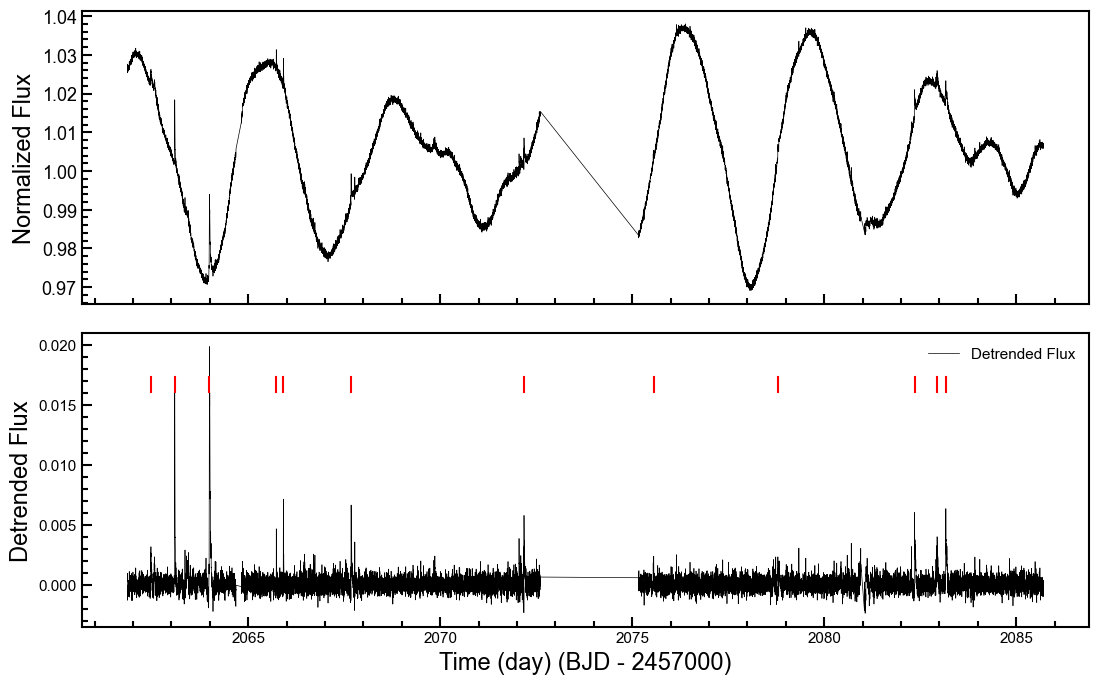

In [23]:
tessBJD = detectors["detector_s0028"].tessBJD
mPDCSAPflux = detectors["detector_s0028"].mPDCSAPflux
s2mPDCSAPflux = detectors["detector_s0028"].s2mPDCSAPflux
peaktime = detectors["detector_s0028"].peaktime

plt.rcParams["xtick.major.width"] = 1.5
plt.rcParams["ytick.major.width"] = 1.5
plt.rcParams["axes.linewidth"] = 1.5
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["ytick.major.size"] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams["xtick.minor.size"] = 4
plt.rcParams["ytick.minor.size"] = 4
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

# 2つのサブプロットを作成 (生の光度曲線とデトレンド後)
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13, 8))
fig.subplots_adjust(hspace=0.1)  # サブプロット間の垂直方向のスペースを調整

# 1つ目のサブプロット: 生の光度曲線
axs[0].plot(tessBJD, mPDCSAPflux, color="black", linestyle="-", label="Normalized Flux", lw=0.5)
axs[0].set_ylabel("Normalized Flux", fontsize=17)
axs[0].tick_params(labelsize=13)
# axs[0].legend(loc='upper right', fontsize=11).get_frame().set_alpha(0)
# axs[0].title(title, fontsize=17)
# 2つ目のサブプロット: デトレンド後
if s2mPDCSAPflux is not None:
    axs[1].plot(tessBJD, s2mPDCSAPflux, color="black", linestyle="-", label="Detrended Flux", lw=0.5)

    # フレアのピーク位置を線で示す
    if peaktime is not None:
        ymin = np.max(s2mPDCSAPflux * 1.1)
        ymax = np.max(s2mPDCSAPflux * 1.3)
        for peak in peaktime:
            # ここでのy座標の範囲は適宜調整してください。
            # Plotlyのy=[0.023, 0.0243]は相対的な範囲なので、
            # Matplotlibではデータに合わせて絶対的なy軸の範囲を考慮する必要があります。
            # 例として、y軸の最小値から少し上の範囲を仮定しています。
            axs[1].axvline(x=peak, ymin=0.8, ymax=0.85, color="red", linestyle="-", linewidth=1.5)
            # もしデータに合わせてy座標を調整したい場合は、以下のようにすることもできます。
            # axs[1].plot([peak, peak], [min_flux_val * 1.02, min_flux_val * 1.05]
            #             color="red", linestyle="--", linewidth=1)

    axs[1].set_xlabel("Time (day) (BJD - 2457000)", fontsize=17)  # Plotlyに合わせてラベルを修正
    axs[1].set_ylabel("Detrended Flux", fontsize=17)
    axs[1].tick_params(labelsize=13)
    # axs[1].legend(loc='upper right', fontsize=11).get_frame().set_alpha(0)
    plt.tick_params(labelsize=11)
    leg = plt.legend(loc="upper right", fontsize=11)
    leg.get_frame().set_alpha(0)  # 背景を完全に透明にする
    plt.savefig(PROJECT_ROOT / "outputs" / "s0028_DSTucA_lightcurve.pdf", format="pdf", bbox_inches="tight")

# グラフタイトル
# fig.title(title, fontsize=16)

plt.show()

In [24]:
sum_flare_number = 0.0
sum_obs_time = 0.0
for detector in detectors.values():
    sum_flare_number += detector.flare_number
    sum_obs_time += detector.precise_obs_time
print(sum_flare_number)
print(sum_obs_time)
frequency = sum_flare_number / sum_obs_time
print(frequency)

37.0
114.15022113728719
0.3241342822761641


In [25]:
sflux = np.array([])
for detector in detectors.values():
    sflux = np.append(sflux, detector.mPDCSAPflux * detector.flux_mean)
    ave = np.mean(sflux)
    print(f"mean={detector.flux_mean}")
print(ave)

mean=119633.99533564149
mean=119633.99533564149
mean=119633.99533564149
mean=119633.99533564149
mean=119633.99533564149
119633.99532108034


In [26]:
detectors["detector_s0067"].flare_number

np.int64(4)

In [27]:
# plot_flare() メソッドでフレアをプロット
detectors["detector_s0027"].plot_flare()

In [28]:
time = detectors["detector_s0027"].tessBJD
flux = detectors["detector_s0027"].mPDCSAPflux * 100

diff_bjd = np.diff(detectors["detector_s0027"].tessBJD)
gap_indices = np.where(diff_bjd >= 0.2)[0]

time_excluded = time.copy()
flux_excluded = flux.copy()

fig = make_subplots(rows=1, cols=1)

for i in range(len(gap_indices)):
    exclude_index = gap_indices[i]
    time_excluded[exclude_index] = np.nan
    flux_excluded[exclude_index] = np.nan
    fig.add_trace(
        go.Scatter(
            x=[time[exclude_index]], y=[flux[exclude_index]], mode="markers", marker=dict(color="blue", size=1), name="Excluded Point"
        ),
        row=1,
        col=1,
    )

fig.add_trace(
    go.Scatter(x=time_excluded, y=flux_excluded, mode="lines", line=dict(color="blue", width=1), name="Flux Line"),
    row=1,
    col=1,
)

fig.update_layout(
    xaxis_title={"text": "Period(day)", "font": {"size": 50}},
    yaxis_title={"text": "Nomalized Flux(%)", "font": {"size": 40}},
    xaxis={"tickfont": {"size": 30}},
    yaxis={"tickfont": {"size": 30}},
    showlegend=False,
    title=dict(text="Fig.2 Lightcurve of DS Tuc", font=dict(size=40), x=0.5, y=0.94),
    height=700,
    width=1300,
)

fig.show()


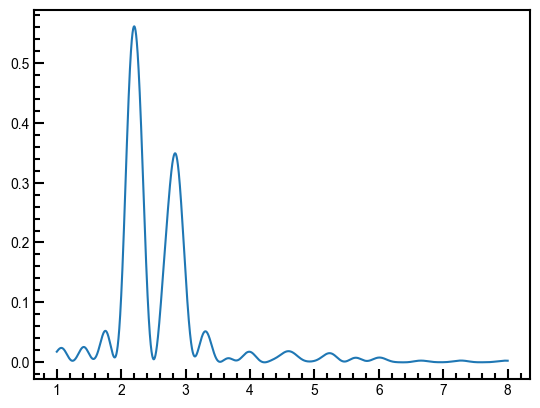

In [29]:
import matplotlib.pyplot as plt

# 2.4～3.0を1000等分して、その中のどれが自転周期なのかを探す
frequency = 1 / np.linspace(1.0, 8.0, 10000)
total_power = np.array([])
for detector in detectors.values():
    total_power = np.append(total_power, detector.power)
period = 1 / frequency
plt.plot(period, detectors["detector_s0027"].power)

In [30]:
total_bjd = np.array([])
total_flux = np.array([]) * 100 - 100
for detector in detectors.values():
    total_bjd = np.append(total_bjd, detector.tessBJD)
    total_flux = np.append(total_flux, detector.mPDCSAPflux)

diff_bjd = np.diff(total_bjd)
gap_indices = np.where(diff_bjd >= 0.2)[0]

fig = make_subplots(rows=1, cols=1)

for i in range(len(gap_indices)):
    exclude_index = gap_indices[i]
    total_bjd[exclude_index] = np.nan
    total_flux[exclude_index] = np.nan
    fig.add_trace(
        go.Scatter(
            x=[total_bjd[exclude_index]],
            y=[total_flux[exclude_index]],
            mode="markers",
            marker=dict(color="blue", size=1),
            name="Excluded Point",
        ),
        row=1,
        col=1,
    )

fig.add_trace(
    go.Scatter(x=total_bjd, y=total_flux, mode="lines", line=dict(color="blue", width=1), name="Flux Line"),
    row=1,
    col=1,
)

fig.update_layout(
    xaxis_range=[1850, 2000],
    xaxis_title={"text": "時間(日)", "font": {"size": 50}},
    yaxis_title={"text": "平均の明るさに対する明るさ(%)", "font": {"size": 35}},
    xaxis={"tickfont": {"size": 30}},
    yaxis={"tickfont": {"size": 30}},
    showlegend=False,
    height=500,
    width=1700,
)

fig.show()